# IDS Bayesian Interferometry

In [1]:
from pymc3 import *
import numpy as np

In [2]:
def show_fft_image(img_fft):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
        
    img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    plt.show()

## Creating artificial data

In [3]:
size = 2
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
SIGMA = 5

I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
Cx = np.clip(Cx,0,255)
Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
Cy = np.clip(Cy,0,255)

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print 'min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI])

min I: 5.0 at (19,22)
max I: 174.0 at (23,30)



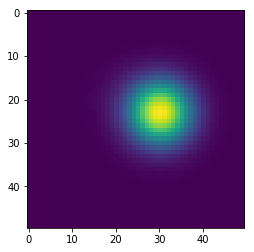

In [4]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.show()

img = Im_sinthc #rename variable

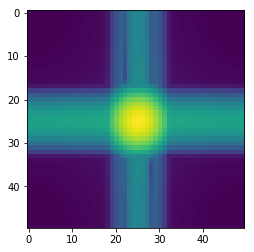

In [5]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

show_fft_image(np.log(img_fftabs+1e-12))

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

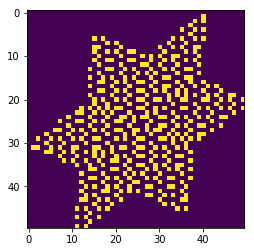

In [6]:
from masking import *

## Parameters
B_max = 1
antennas = 24
typeArray = 'VLA'
sigma = B_max/6

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

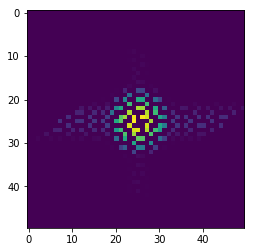

In [7]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+0.01)
show_fft_image(measurements_abs)


## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace

\end{array}\right]$$

In [12]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,Cx,Cy, numberOfBasis = 2):
    #print "U shape: %s, U type: %s\nl type: %s\nCx and Cy type: %s"%(U.shape, type(U), type(l), type(Cx))
    
    u = U[:,0]
    u_aux = u[:,np.newaxis]
    v = U[:,1]
    v_aux = v[:,np.newaxis]
    
    
    A = tt.exp(-2.0 * PI * (u_aux * u_aux + v_aux * v_aux) * l*l)
    A_aux = A.repeat(numberOfBasis,axis=1)
    
    #print "Amplitude shape: %s, Amplitude type: %s" %(A_aux.eval().shape, type(A))
    # argument = 2.0 * PI * (np.outer(u,Cx) + np.outer(v,Cy))
    argument = 2.0 * PI * (u[:,None]*Cx[None,:] + v[:,None]*Cy[None,:])
    #print "argument shape: %s, argument type: %s" %(argument.shape, type(argument))
    
    cosPart = tt.cos(argument)
    sinPart = tt.sin(argument)
    
    #print "cosPart shape: %s, cosPart type: %s" %(cosPart.eval().shape, type(cosPart))

    RePart = tt.mul(A_aux,cosPart)
    ImPart = tt.mul(A_aux,sinPart)
    
    #print "RePart shape: %s, RePart type: %s" %(RePart.eval().shape, type(cosPart))
    
    alpha_aux = alpha
    #print "alpha shape: %s, alpha type: %s" %(alpha.shape, type(alpha))
    
    return tt.sum(tt.mul(alpha_aux,RePart), axis = 1), tt.sum(tt.mul(alpha_aux,ImPart), axis = 1)

In [25]:
numberOfSamplings = U.shape[0]
numberOfBasis = size

init_alpha = (10**(10))*np.ones([1,numberOfBasis])
init_U = U
init_Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cx = np.clip(Cx,0,255)
init_Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cy = np.clip(Cy,0,255)
init_sigma = np.random.randn(2,2)

PHI_Re, PHI_Im = Vobs_function(init_U,1,init_alpha,init_Cx,init_Cy)
print PHI_Re.eval(), PHI_Im.eval()

[  5.52402489e-015   4.57990747e-165   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.54220214e-004   2.25662604e-061   2.17360093e-091   3.49387985e-214
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   2.43231134e-001   2.95806923e-012   5.32078661e-045   1.46960788e-069
   5.56988044e-176   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   1.52574255e-039   1.07987366e-148   5.16756924e-236   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   4.37508679e-034   8.17022403e-037   2.64343710e-

In [14]:
#from scipy import optimize

numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = Model()

init_alpha = 1*np.ones([1,numberOfBasis])
init_Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cx = np.clip(Cx,0,255)
init_Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(numberOfBasis)).astype('int')
init_Cy = np.clip(Cy,0,255)
init_sigma = np.random.randn(2,2)

with rbf_model:
    alpha_model = Normal('alpha', mu=init_alpha, sd=10, shape = [1,numberOfBasis])
    Cx_model = Normal('Cx', mu=init_Cx, sd=10, shape = numberOfBasis)
    Cy_model = Normal('Cy', mu=init_Cy, sd=10, shape = numberOfBasis)
    l_model = HalfNormal('l', sd=1, shape = 1)
    sigma_model = Lognormal('sigma', 1*np.ones((2,2)), np.ones(2), shape=(2,2), testval=init_sigma)
#     a = Normal('a', mu=1, sd=10, shape = 1)
#     b = Normal('b', mu=1, sd=10, shape = 1)
#     c = Normal('c', mu=1, sd=10, shape = 1)
#     sigma_model.reshape((2,2))

    PHI_Re, PHI_Im = Vobs_function(U, l_model, alpha_model, Cx_model, Cy_model)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)
    
    V_obs = MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    
    n_samples = 1000
    #step = Slice()
    #sample(n_samples, step)
    estimation = find_MAP(model = rbf_model)
    print estimation

Optimization terminated successfully.
         Current function value: 10000000000000000159028911097599180468360808563945281389781327557747838772170381060813469985856815104.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


ValueError: Optimization error: max, logp or dlogp at max have non-finite values. Some values may be outside of distribution support. max: {'alpha': array([[ 1.,  1.]]), 'Cy': array([ 30.,  22.]), 'sigma_log_': array([[        nan,  0.42285378],
       [ 0.08399885, -0.28281917]]), 'l_log_': array([-0.22579135]), 'Cx': array([ 23.,  19.])} logp: array(nan) dlogp: array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])Check that 1) you don't have hierarchical parameters, these will lead to points with infinite density. 2) your distribution logp's are properly specified. Specific issues: 
sigma_log_.dlogp bad: [        nan  0.57714622  0.91600115  1.28281917]
sigma_log_.logp bad: nan
sigma_log_.value bad: [[        nan  0.42285378]
 [ 0.08399885 -0.28281917]]

In [ ]:
init_sigma